# Perform seasonal and yearly trend decomposition of sea ice

## Data

### Locations for model development

A set of locations to develop the model(s) were provided by Eugene in `ak_ice_locs.csv`.

### CFSV2 experimental data

The data available to create the predictive models is derived from an "experimental" CFS V2 model with improved treatment of sea ice.

The data was provided in grib2 files in two formats: a 45-day forecast and "seasonal".

#### 45-day forecast

```
variables = {
    'ocn': {
        'temp': 'TMP_GDS0_SFC_ave6h',
        'salt': 'SALTY_GDS0_DBSL_ave6h',
        'ice_thk': 'ICETK_GDS0_SFC_ave6h',
    },
    'sic': {
        'ice_conc': 'ICE_C_GDS0_SFC_ave6h'
    },
    'sst': {
        'temp': 'POT_GDS0_DBSL_ave6h'
    }
}
```

#### Seasonal model

The seasonal model has a *ton* of variables and the time is weird, so I'm going to skip that for now.

## Methods

### 1. Build a LOESS model using only the 45-day model.

Attempt to build a model where input from `time=0` attempts to predict sea ice thickness and concentration 1 day, 1 week, and 1 month out.

In [1]:
from pathlib import Path

import geopandas as gdp
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.seasonal import STL 

register_matplotlib_converters()

## 1. Load the locations

In [2]:
locs = pd.read_csv("ak_ice_locs.csv")

In [3]:
locs

,name,lon,lat
0,PAWIC,-160.05500,70.6870
1,PAWI10,-160.36500,70.7750
2,PAWI20,-160.72000,70.8800
3,PABRC,-156.87583,71.3128
4,PTBRC,-156.47000,71.4200
...,...,...,...
309,N56W175,-175.00000,56.0000
310,N55W165,-165.00000,55.0000
311,N55W167,-167.00000,55.0000
312,N55W169,-169.00000,55.0000


## 2. Identify the variables available

### 2a. 45 day forecasts

- ocn:
    - TMP_GDS0_SFC_ave6h (temp)
    - SALTY_GDS0_DBSL_ave6h (salt)
    - ICETK_GDS0_SFC_ave6h (ice thickness)
- sic:
    - ICE_C_GDS0_SFC_ave6h (ice concentration? cover?)
- sst:
    - POT_GDS0_DBSL_ave6h (temp)

In [4]:
var_map = {
    'ocn': {
        'temp': 'TMP_GDS0_SFC_ave6h',
        'salt': 'SALTY_GDS0_DBSL_ave6h',
        'ice_thk': 'ICETK_GDS0_SFC_ave6h',
    },
    'sic': {
        'ice_conc': 'ICE_C_GDS0_SFC_ave6h'
    },
    'sst': {
        'temp': 'POT_GDS0_DBSL_ave6h'
    }
}

In [5]:
ocn_files = list(Path('/data/assets/s2s/45day/ocn/').glob('**/*ocn*'))
ocn_files.sort()
ocn_files = [str(f) + '.grb' for f in ocn_files]

sic_files = list(Path('/data/assets/s2s/45day/sic/').glob('**/*sic*'))
sic_files.sort()
sic_files = [str(f) + '.grb' for f in sic_files]

sst_files = list(Path('/data/assets/s2s/45day/sst/').glob('**/*sst*'))
sst_files.sort()
sst_files = [str(f) + '.grb' for f in sst_files]

print(len(ocn_files), len(sic_files), len(sst_files))

files = {
    'ocn': ocn_files,
    'sic': sic_files,
    'sst': sst_files
}

516 3346 3345


In [26]:
test_sic_files = list(Path('/data/assets/s2s/45day/sic/2019').glob('**/*sic*'))
test_sic_files.sort()

In [27]:
test_sic_files[:5]

[PosixPath('/data/assets/s2s/45day/sic/2019/iceCFSm5eCSISr1.sic.2019010100'),
 PosixPath('/data/assets/s2s/45day/sic/2019/iceCFSm5eCSISr1.sic.2019010200'),
 PosixPath('/data/assets/s2s/45day/sic/2019/iceCFSm5eCSISr1.sic.2019010300'),
 PosixPath('/data/assets/s2s/45day/sic/2019/iceCFSm5eCSISr1.sic.2019010400'),
 PosixPath('/data/assets/s2s/45day/sic/2019/iceCFSm5eCSISr1.sic.2019010500')]

## 2. Gather data from a single varialbe at PAWIC in all files and aggregate into a single data container

Data to gather:
- "Best" time steps (the first output of the forecast) for all  45-day forecast

In [11]:
from dask.distributed import Client, progress
from dask import delayed

In [12]:
client = Client('estuaries01.ib.axiomptk:9000')

In [13]:
client

Client Scheduler: tcp://estuaries01.ib.axiomptk:9000 Dashboard: http://estuaries01.ib.axiomptk:9001/status,Cluster Workers: 9 Cores: 36 Memory: 136.83 GiB


In [14]:
### Function to extract data given station + filename
# POT_GDS0_DBSL_ave6h
# location = (lon, lat)

# Anywhere from 100 to 250 ms to extract a single time step from a file.
def get_station(fname, var='temp', coords=(-160.05500, 70.6870), var_map=var_map):
    if 'ocn' in fname:
        var = var_map['ocn'][var]
    elif 'sic' in fname:
        var = var_map['sic'][var]
    elif 'sst' in fname:
        var = var_map['sst'][var]
    else:
        raise ValueError(f'Cannot identify file type. fname={fname}')
    
    lon, lat = coords
    with xr.open_dataset(fname, engine='pynio') as ds:
        return ds[var].sel(dict(g0_lat_1=lat, g0_lon_2=lon), method='nearest').isel(initial_time0_hours=0)

In [15]:
# Test an SST file
# - make sure var in station_wrapper is in file
result = client.submit(get_station, sst_files[0])
result.result()

<xarray.DataArray 'POT_GDS0_DBSL_ave6h' ()>
array(277.709991)
Coordinates:
    initial_time0_hours  datetime64[ns] 2012-01-01T06:00:00
    g0_lat_1             float32 70.75
    g0_lon_2             float32 0.25
Attributes:
    sub_center:               Environmental Modeling Center
    center:                   US National Weather Service - NCEP (WMC)
    long_name:                Potential temperature
    units:                    K
    level_indicator:          [160]
    gds_grid_type:            [0]
    parameter_table_version:  [2]
    parameter_number:         [13]
    model:                    Analysis from GDAS (Global Data Assimilation Sy...
    level:                    [5]
    forecast_time:            [1]
    forecast_time_units:      6 hours

In [16]:
# Test an OCN file
# - make sure var in station_wrapper is in file
result = client.submit(get_station, ocn_files[0])
result.result()

<xarray.DataArray 'TMP_GDS0_SFC_ave6h' ()>
array(280.540009)
Coordinates:
    initial_time0_hours  datetime64[ns] 2019-10-01T06:00:00
    g0_lat_1             float32 70.75
    g0_lon_2             float32 0.25
Attributes:
    sub_center:               Environmental Modeling Center
    center:                   US National Weather Service - NCEP (WMC)
    long_name:                Temperature
    units:                    K
    level_indicator:          [1]
    gds_grid_type:            [0]
    parameter_table_version:  [2]
    parameter_number:         [11]
    model:                    Analysis from GDAS (Global Data Assimilation Sy...
    forecast_time:            [1]
    forecast_time_units:      6 hours

In [17]:
# Test a sic file
# - make sure var in station_wrapper is in file
result = client.submit(get_station, sic_files[0], var='ice_conc')
result.result()

<xarray.DataArray 'ICE_C_GDS0_SFC_ave6h' ()>
array(0.)
Coordinates:
    initial_time0_hours  datetime64[ns] 2012-01-01T06:00:00
    g0_lat_1             float32 70.75
    g0_lon_2             float32 0.25
Attributes:
    sub_center:               Environmental Modeling Center
    center:                   US National Weather Service - NCEP (WMC)
    long_name:                Ice concentration (ice=1;no ice=0)
    units:                    fraction
    level_indicator:          [1]
    gds_grid_type:            [0]
    parameter_table_version:  [2]
    parameter_number:         [91]
    model:                    Analysis from GDAS (Global Data Assimilation Sy...
    forecast_time:            [1]
    forecast_time_units:      6 hours

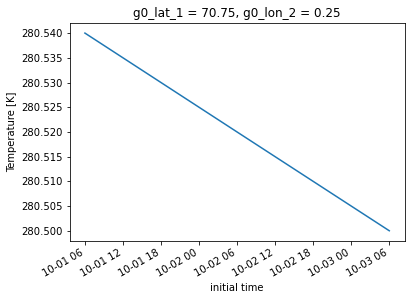

In [21]:
# Test a few files
# - make sure var in station_wrapper is in file
futures = client.map(get_station, ocn_files[:3])
results = client.gather(iter(futures))
results = list(results)
ocn_ds = xr.concat(results, dim='initial_time0_hours')
ocn_ds.plot()

### 2b. Create DataArrays for all of the variables

In [22]:
def get_bad_files(fname, var='temp', coords=(-160.05500, 70.6870), var_map=var_map):
    if 'ocn' in fname:
        var = var_map['ocn'][var]
    elif 'sic' in fname:
        var = var_map['sic'][var]
    elif 'sst' in fname:
        var = var_map['sst'][var]
    else:
        raise ValueError(f'Cannot identify file type. fname={fname}')
    
    lon, lat = coords
    try:
        with xr.open_dataset(fname, engine='pynio') as ds:
            data = ds[var].sel(dict(g0_lat_1=lat, g0_lon_2=lon), method='nearest').isel(initial_time0_hours=0)
            return None
    except:
        return fname

In [30]:
%%time
futures = client.map(get_station, sic_files, var='ice_conc')
results = client.gather(iter(futures))
results = list(results)
sic_ds = xr.concat(results, dim='initial_time0_hours')
#sic_ds.plot()

CPU times: user 51.5 s, sys: 36.9 s, total: 1min 28s
Wall time: 5min 50s


In [31]:
# Try map-reduce the xr.concat
@delayed
def agg(x, y):
    return xr.concat([x, y], dim='initial_time0_hours')


def bfs_merge(seq):
    if len(seq) < 2:
        return seq
    middle = len(seq) // 2
    left = bfs_merge(seq[:middle])
    right = bfs_merge(seq[middle:])
    if not right:
        return left
    return [agg(left[0], right[0])]

def dfs_merge(seq):
    if len(seq) < 2:
        return seq

In [34]:
%time
futures = client.map(get_station, sic_files, var='ice_conc')
results = client.gather(iter(futures))
results = list(results)
sic_combined = bfs_merge(results)[0]
sic_combined = sic_combined.compute()

CPU times: user 6 µs, sys: 3 µs, total: 9 µs
Wall time: 17.4 µs


In [42]:
%%time
futures = client.map(get_station, ocn_files, var='salt')
results = client.gather(iter(futures))
results = list(results)
ocn_salt_combined = bfs_merge(results)[0]
ocn_salt_combined = ocn_salt_combined.compute()

CPU times: user 2.26 s, sys: 224 ms, total: 2.48 s
Wall time: 3min 33s


In [43]:
%%time
futures = client.map(get_station, ocn_files, var='temp')
results = client.gather(iter(futures))
results = list(results)
ocn_temp_combined = bfs_merge(results)[0]
ocn_temp_combined = ocn_temp_combined.compute()

CPU times: user 2.12 s, sys: 205 ms, total: 2.32 s
Wall time: 3min 25s


In [44]:
test_ds = xr.merge([ocn_salt_combined, ocn_temp_combined])

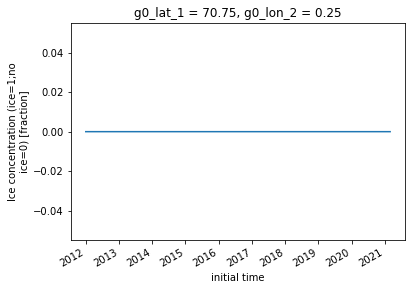

In [51]:
sic_combined.plot()

In [59]:
sic_combined.to_netcdf('test.nc')

In [58]:
xr.merge([test_ds, sic_combined])

ValueError: cannot reindex or align along dimension 'initial_time0_hours' because the index has duplicate values

In [49]:
xr.combine_by_coords([sic_combined, test_ds])

TypeError: '>' not supported between instances of 'numpy.ndarray' and 'str'

In [32]:
# Try map-reduce the xr.concat
@delayed
def agg(x, y):
    return xr.concat([x, y], dim='initial_time0_hours')


def bfs_merge(seq):
    if len(seq) < 2:
        return seq
    middle = len(seq) // 2
    left = bfs_merge(seq[:middle])
    right = bfs_merge(seq[middle:])
    if not right:
        return left
    return [agg(left[0], right[0])]

def dfs_merge(seq):
    if len(seq) < 2:
        return seq

In [37]:
add_two = bfs_merge(results)[0]

In [38]:
add_two.compute()

<xarray.DataArray 'TMP_GDS0_SFC_ave6h' (initial_time0_hours: 516)>
array([280.54000854, 280.51998901, 280.5       , 280.48001099,
       280.45999146, 280.44000244, 280.44000244, 280.45001221,
       280.45001221, 280.45001221, 280.44000244, 280.42001343,
       280.36999512, 280.32000732, 280.27999878, 280.23001099,
       280.17999268, 280.11999512, 280.02999878, 279.98001099,
       279.91000366, 279.66000366, 279.45999146, 279.39001465,
       279.27999878, 279.22000122, 279.22000122, 279.17999268,
       279.16000366, 279.13000488, 279.07000732, 279.        ,
       278.92001343, 278.82998657, 278.76000977, 278.70999146,
       278.67001343, 278.61999512, 278.57998657, 278.57998657,
       278.54998779, 278.54000854, 278.52999878, 278.5       ,
       278.5       , 278.5       , 278.5       , 278.5       ,
       278.48001099, 278.47000122, 278.45001221, 278.45999146,
       278.45001221, 278.48999023, 278.47000122, 278.44000244,
       278.41000366, 278.35998535, 278.29998779, 278.19000244,
       278.07000732, 278.07998657, 277.92001343, 277.8999939 ,
       277.92999268, 277.86999512, 277.82000732, 277.82000732,
       277.79998779, 277.73999023, 277.70001221, 277.66000366,
       277.6000061 , 277.61999512, 277.64001465, 277.67001343,
       277.66000366, 277.67999268, 277.6499939 , 277.63000488,
...
       277.57998657, 277.64001465, 277.57998657, 277.6000061 ,
       277.57000732, 277.54998779, 277.57000732, 277.57998657,
       277.58999634, 277.58999634, 277.6499939 , 277.75      ,
       277.64001465, 277.57998657, 277.54998779, 277.55999756,
       277.54998779, 277.51000977, 277.52999878, 277.57000732,
       277.57998657, 277.6000061 , 277.6000061 , 277.6000061 ,
       277.58999634, 277.54998779, 277.52999878, 277.54998779,
       277.48999023, 277.48001099, 277.48001099, 277.48001099,
       277.48001099, 277.48001099, 277.5       , 277.48999023,
       277.51998901, 277.54998779, 277.54000854, 277.51998901,
       277.5       , 277.47000122, 277.42001343, 277.35998535,
       277.32998657, 277.29998779, 277.26998901, 277.26000977,
       277.25      , 277.23001099, 277.20999146, 277.19000244,
       277.16000366, 277.1499939 , 277.14001465, 277.14001465,
       277.1499939 , 277.14001465, 277.13000488, 277.11999512,
       277.11999512, 277.1000061 , 277.07998657, 277.04000854,
       277.        , 277.        , 276.98001099, 276.98999023,
       277.        , 277.01000977, 277.02999878, 277.04000854,
       277.1000061 , 277.14001465, 277.19000244, 277.25      ,
       277.30999756, 277.30999756, 277.30999756, 277.26998901])
Coordinates:
  * initial_time0_hours  (initial_time0_hours) datetime64[ns] 2019-10-01T06:0...
    g0_lat_1             float32 70.75
    g0_lon_2             float32 0.25
Attributes:
    sub_center:               Environmental Modeling Center
    center:                   US National Weather Service - NCEP (WMC)
    long_name:                Temperature
    units:                    K
    level_indicator:          [1]
    gds_grid_type:            [0]
    parameter_table_version:  [2]
    parameter_number:         [11]
    model:                    Analysis from GDAS (Global Data Assimilation Sy...
    forecast_time:            [1]
    forecast_time_units:      6 hours

In [39]:
%%time
futures = client.map(get_station, ocn_files, var='salt')
results = client.gather(iter(futures))
results = list(results)
combine = bfs_merge(results)[0]
ocn_salt_ds = combine.compute()

CPU times: user 3.17 s, sys: 200 ms, total: 3.37 s
Wall time: 4min 44s


In [ ]:
%%time
futures = client.map(get_station, ocn_files, var='temp')
results = client.gather(iter(futures))
results = list(results)
ocn_tmp_ds = xr.concat(results, dim='initial_time0_hours')
ocn_tmp_ds.plot()

In [ ]:
%%time
futures = client.map(get_station, ocn_files, var='ice_thk'')
results = client.gather(iter(futures))
results = list(results)
ocn_icethk_ds = xr.concat(results, dim='initial_time0_hours')
ocn_icethk_ds.plot()

In [132]:
%%time
futures = client.map(get_station, ocn_files, var='ice_thk')
results = client.gather(iter(futures))
results = list(results)
ocn_tmp_ds = xr.concat(results, dim='initial_time0_hours')
ocn_tmp_ds.plot()

KeyboardInterrupt: 

In [133]:
%%time
futures = client.map(get_station, sst_files, var='temp')
results = client.gather(iter(futures))
results = list(results)
ocn_tmp_ds = xr.concat(results, dim='initial_time0_hours')
ocn_tmp_ds.plot()

KeyboardInterrupt: 